In [1]:
import numpy as np
import pandas as pd
import scipy.stats as stats
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="whitegrid")

In [2]:
class NaiveBayesClassifier():
    '''
    Bayes Theorem form
    P(y|X) = P(X|y) * P(y) / P(X)
    '''
    def calc_prior(self, features, target):
        '''
        prior probability P(y)
        calculate prior probabilities
        '''
        self.prior = (features.groupby(target).apply(lambda x: len(x)) / self.rows).to_numpy()

        return self.prior
    
    def calc_statistics(self, features, target):
        '''
        calculate mean, variance for each column and convert to numpy array
        ''' 
        self.mean = features.groupby(target).apply(np.mean).to_numpy()
        self.var = features.groupby(target).apply(np.var).to_numpy()
              
        return self.mean, self.var
    
    def gaussian_density(self, class_idx, x):     
        '''
        calculate probability from gaussian density function (normally distributed)
        we will assume that probability of specific target value given specific class is normally distributed 
        
        probability density function derived from wikipedia:
        (1/√2pi*σ) * exp((-1/2)*((x-μ)^2)/(2*σ²)), where μ is mean, σ² is variance, σ is quare root of variance (standard deviation)
        '''
        mean = self.mean[class_idx]
        var = self.var[class_idx]
        numerator = np.exp((-1/2)*((x-mean)**2) / (2 * var))
#         numerator = np.exp(-((x-mean)**2 / (2 * var)))
        denominator = np.sqrt(2 * np.pi * var)
        prob = numerator / denominator
        return prob
    
    def calc_posterior(self, x):
        posteriors = []

        # calculate posterior probability for each class
        for i in range(self.count):
            prior = np.log(self.prior[i]) ## use the log to make it more numerically stable
            conditional = np.sum(np.log(self.gaussian_density(i, x))) # use the log to make it more numerically stable
            posterior = prior + conditional
            posteriors.append(posterior)
        # return class with highest posterior probability
        return self.classes[np.argmax(posteriors)]
     

    def fit(self, features, target):
        self.classes = np.unique(target)
        self.count = len(self.classes)
        self.feature_nums = features.shape[1]
        self.rows = features.shape[0]
        
        self.calc_statistics(features, target)
        self.calc_prior(features, target)
        
    def predict(self, features):
        preds = [self.calc_posterior(f) for f in features.to_numpy()]
        return preds

    def accuracy(self, y_test, y_pred):
        accuracy = np.sum(y_test == y_pred) / len(y_test)
        return accuracy

    def visualize(self, y_true, y_pred, target):
        
        tr = pd.DataFrame(data=y_true, columns=[target])
        pr = pd.DataFrame(data=y_pred, columns=[target])
        
        
        fig, ax = plt.subplots(1, 2, sharex='col', sharey='row', figsize=(15,6))
        
        sns.countplot(x=target, data=tr, ax=ax[0], palette='viridis', alpha=0.7, hue=target, dodge=False)
        sns.countplot(x=target, data=pr, ax=ax[1], palette='viridis', alpha=0.7, hue=target, dodge=False)
        

        fig.suptitle('True vs Predicted Comparison', fontsize=20)

        ax[0].tick_params(labelsize=12)
        ax[1].tick_params(labelsize=12)
        ax[0].set_title("True values", fontsize=18)
        ax[1].set_title("Predicted values", fontsize=18)
        plt.show()


In [3]:

# pre-process dataset for training 

# upload Iris dataset -  shape is (150, 5)
df = pd.read_csv("spotify-dataset.csv")
# df = pd.read_csv("iris.csv")
# shuffle dataset with sample
df = df.sample(frac=1, random_state=1).reset_index(drop=True)
# df shape
print(df.shape)

(1994, 15)


In [4]:
df.drop(['Title', 'Artist', 'Year', 'Index'], axis=1, inplace=True)

In [5]:
df

,Top Genre,Beats Per Minute (BPM),Energy,Danceability,Loudness (dB),Liveness,Valence,Length (Duration),Acousticness,Speechiness,Popularity
0,adult standards,76,40,34,-9,11,7,291,76,4,47
1,british soul,104,82,72,-7,24,82,249,15,3,49
2,irish rock,96,60,53,-6,11,35,305,0,2,57
3,australian rock,119,50,75,-9,9,34,258,1,4,63
4,album rock,60,22,23,-13,27,18,214,95,3,66
...,...,...,...,...,...,...,...,...,...,...,...
1989,dance rock,116,19,56,-13,11,12,321,73,3,53
1990,album rock,77,57,54,-8,9,73,290,1,16,66
1991,classic uk pop,167,52,18,-8,6,42,222,39,3,48
1992,pop,180,66,51,-7,12,46,228,3,4,79


In [6]:
# lower the attribute
df['Top Genre'] = (df["Top Genre"].str.strip()).str.lower()

# drop genres that have less than 20 instances
to_remove = [genre for genre in df['Top Genre'].unique() if df['Top Genre'].value_counts()[genre] < 20] 
for r in to_remove:
    df = df[df['Top Genre'] != r]

In [7]:
# convert negative values to positive, because the percenption of sound is relative (-N dB == N dB in human ear)
df['Loudness (dB)'] = df['Loudness (dB)'].abs()

In [8]:
df['Length (Duration)'] = pd.to_numeric(df['Length (Duration)'].str.replace(',',''))

In [9]:
# set features and target
# X, y = df.iloc[:, :-1], df.iloc[:, -1]
X, y = df.drop('Top Genre', axis=1), df.iloc[:, 0]
print(X)

      Beats Per Minute (BPM)  Energy  Danceability  Loudness (dB)  Liveness  \
0                         76      40            34              9        11   
1                        104      82            72              7        24   
2                         96      60            53              6        11   
4                         60      22            23             13        27   
5                         96      80            22              6         9   
...                      ...     ...           ...            ...       ...   
1989                     116      19            56             13        11   
1990                      77      57            54              8         9   
1991                     167      52            18              8         6   
1992                     180      66            51              7        12   
1993                     175      66            39              6         6   

      Valence  Length (Duration)  Acousticness  Spe

In [10]:
print(y)

0        adult standards
1           british soul
2             irish rock
4             album rock
5       alternative rock
              ...       
1989          dance rock
1990          album rock
1991      classic uk pop
1992                 pop
1993           glam rock
Name: Top Genre, Length: 1465, dtype: object


In [11]:
# # split on train and test 0.7/0.3
X_train, X_test, y_train, y_test = X[:100], X[100:], y[:100], y[100:]

In [12]:
print(X_train)

     Beats Per Minute (BPM)  Energy  Danceability  Loudness (dB)  Liveness  \
0                        76      40            34              9        11   
1                       104      82            72              7        24   
2                        96      60            53              6        11   
4                        60      22            23             13        27   
5                        96      80            22              6         9   
..                      ...     ...           ...            ...       ...   
119                     110      80            58              8         5   
120                     105      76            73              5         6   
121                      97      70            62             10         6   
122                      90      41            63             13        31   
123                     125      80            74              6        26   

     Valence  Length (Duration)  Acousticness  Speechiness  Pop

In [13]:
print(X_train.shape, y_train.shape)


(100, 10) (100,)


In [14]:
print(X_test.shape, y_test.shape)

(1365, 10) (1365,)


In [15]:
# train the model
x = NaiveBayesClassifier()

x.fit(X_train, y_train)

In [16]:
predictions = x.predict(X_test)

C:\Users\Luis\Anaconda3\envs\tfg_chatbot\lib\site-packages\ipykernel_launcher.py:34: RuntimeWarning: divide by zero encountered in true_divide
C:\Users\Luis\Anaconda3\envs\tfg_chatbot\lib\site-packages\ipykernel_launcher.py:37: RuntimeWarning: invalid value encountered in true_divide
C:\Users\Luis\Anaconda3\envs\tfg_chatbot\lib\site-packages\ipykernel_launcher.py:46: RuntimeWarning: divide by zero encountered in log
C:\Users\Luis\Anaconda3\envs\tfg_chatbot\lib\site-packages\ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in true_divide


In [17]:
x.accuracy(y_test, predictions)

0.02490842490842491

In [18]:
y_test.value_counts(normalize=True)

album rock           0.284249
adult standards      0.082051
dutch pop            0.062271
alternative rock     0.057143
dance pop            0.055678
dutch indie          0.049817
alternative metal    0.046154
dutch cabaret        0.035897
modern rock          0.034432
glam rock            0.034432
pop                  0.034432
classic rock         0.033700
dance rock           0.032967
art rock             0.027839
permanent wave       0.026374
british invasion     0.024908
irish rock           0.021978
british soul         0.020513
europop              0.019048
classic uk pop       0.016117
Name: Top Genre, dtype: float64

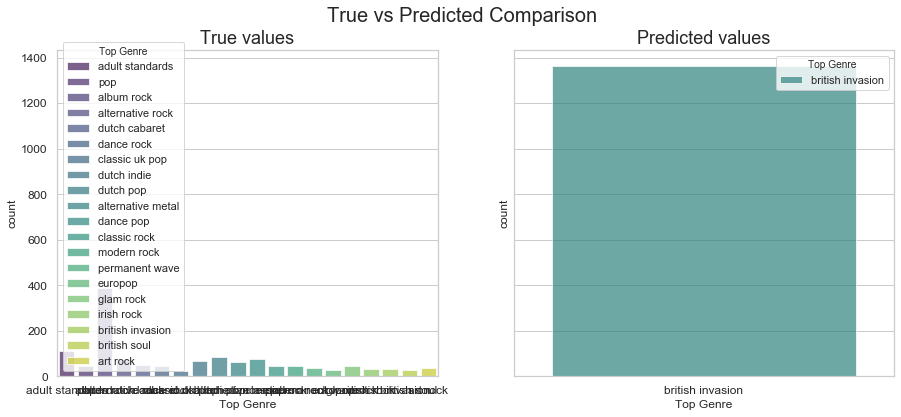

In [19]:
x.visualize(y_test, predictions, 'Top Genre')

In [20]:
X_train.shape

(100, 10)

In [21]:
x.classes, x.feature_nums, x.rows, x.count

(array(['adult standards', 'album rock', 'alternative metal',
        'alternative rock', 'art rock', 'british invasion', 'british soul',
        'classic rock', 'dance pop', 'dance rock', 'dutch cabaret',
        'dutch indie', 'dutch pop', 'europop', 'glam rock', 'irish rock',
        'modern rock', 'permanent wave'], dtype=object),
 10,
 100,
 18)

In [22]:
x.calc_prior(X_train, y_train)

array([0.11, 0.25, 0.07, 0.08, 0.02, 0.02, 0.03, 0.05, 0.07, 0.07, 0.02,
       0.07, 0.03, 0.01, 0.02, 0.04, 0.02, 0.02])

In [23]:
x.prior

array([0.11, 0.25, 0.07, 0.08, 0.02, 0.02, 0.03, 0.05, 0.07, 0.07, 0.02,
       0.07, 0.03, 0.01, 0.02, 0.04, 0.02, 0.02])

In [24]:
x.calc_statistics(X_train, y_train)

(array([[115.54545455,  50.        ,  53.18181818,  10.27272727,
          23.36363636,  62.54545455, 206.        ,  41.90909091,
           4.09090909,  63.72727273],
        [117.32      ,  62.76      ,  48.8       ,  10.24      ,
          17.2       ,  59.72      , 273.16      ,  21.96      ,
           4.04      ,  59.2       ],
        [114.57142857,  80.        ,  48.14285714,   5.        ,
          23.57142857,  40.85714286, 272.57142857,   8.14285714,
           8.57142857,  70.14285714],
        [116.5       ,  78.25      ,  50.375     ,   7.875     ,
           9.125     ,  53.125     , 256.375     ,   4.75      ,
           4.375     ,  68.        ],
        [107.5       ,  46.5       ,  51.5       ,  13.        ,
          20.        ,  57.5       , 335.        ,  17.5       ,
           5.5       ,  55.        ],
        [ 98.5       ,  33.        ,  30.5       ,   9.5       ,
          10.        ,  53.        , 213.        ,  40.5       ,
           3.        ,  66.5  

In [25]:
x.mean

array([[115.54545455,  50.        ,  53.18181818,  10.27272727,
         23.36363636,  62.54545455, 206.        ,  41.90909091,
          4.09090909,  63.72727273],
       [117.32      ,  62.76      ,  48.8       ,  10.24      ,
         17.2       ,  59.72      , 273.16      ,  21.96      ,
          4.04      ,  59.2       ],
       [114.57142857,  80.        ,  48.14285714,   5.        ,
         23.57142857,  40.85714286, 272.57142857,   8.14285714,
          8.57142857,  70.14285714],
       [116.5       ,  78.25      ,  50.375     ,   7.875     ,
          9.125     ,  53.125     , 256.375     ,   4.75      ,
          4.375     ,  68.        ],
       [107.5       ,  46.5       ,  51.5       ,  13.        ,
         20.        ,  57.5       , 335.        ,  17.5       ,
          5.5       ,  55.        ],
       [ 98.5       ,  33.        ,  30.5       ,   9.5       ,
         10.        ,  53.        , 213.        ,  40.5       ,
          3.        ,  66.5       ],
       [11

In [26]:
x.var

array([[1.01388430e+03, 3.28000000e+02, 2.08876033e+02, 1.14710744e+01,
        5.51867769e+02, 7.42429752e+02, 2.28818182e+03, 1.03190083e+03,
        2.80991736e+00, 5.51074380e+01],
       [6.90057600e+02, 3.86342400e+02, 1.50240000e+02, 1.21024000e+01,
        1.23680000e+02, 5.94281600e+02, 8.13605440e+03, 5.25318400e+02,
        1.63840000e+00, 1.29840000e+02],
       [4.95102041e+02, 2.52571429e+02, 2.50122449e+02, 1.14285714e+00,
        6.53959184e+02, 6.74979592e+02, 1.74224490e+03, 2.92979592e+02,
        8.25306122e+01, 5.38367347e+01],
       [1.15425000e+03, 1.12187500e+02, 3.44734375e+02, 6.10937500e+00,
        8.35937500e+00, 4.46109375e+02, 2.47948438e+03, 4.76875000e+01,
        9.84375000e-01, 1.65750000e+02],
       [2.40250000e+02, 1.12225000e+03, 2.25000000e+00, 2.50000000e+01,
        2.56000000e+02, 1.33225000e+03, 4.35600000e+03, 3.06250000e+02,
        6.25000000e+00, 1.60000000e+01],
       [1.12225000e+03, 0.00000000e+00, 2.50000000e-01, 2.50000000e-01,
   

In [27]:
X_train

,Beats Per Minute (BPM),Energy,Danceability,Loudness (dB),Liveness,Valence,Length (Duration),Acousticness,Speechiness,Popularity
0,76,40,34,9,11,7,291,76,4,47
1,104,82,72,7,24,82,249,15,3,49
2,96,60,53,6,11,35,305,0,2,57
4,60,22,23,13,27,18,214,95,3,66
5,96,80,22,6,9,26,291,0,4,37
...,...,...,...,...,...,...,...,...,...,...
119,110,80,58,8,5,42,226,0,4,49
120,105,76,73,5,6,54,228,13,3,61
121,97,70,62,10,6,73,234,1,3,68
122,90,41,63,13,31,70,291,6,3,41


In [28]:
# train the model
x = NaiveBayesClassifier()


x.fit(X_train, y_train)

In [29]:
predictions = x.predict(X_test)

C:\Users\Luis\Anaconda3\envs\tfg_chatbot\lib\site-packages\ipykernel_launcher.py:34: RuntimeWarning: divide by zero encountered in true_divide
C:\Users\Luis\Anaconda3\envs\tfg_chatbot\lib\site-packages\ipykernel_launcher.py:37: RuntimeWarning: invalid value encountered in true_divide
C:\Users\Luis\Anaconda3\envs\tfg_chatbot\lib\site-packages\ipykernel_launcher.py:46: RuntimeWarning: divide by zero encountered in log
C:\Users\Luis\Anaconda3\envs\tfg_chatbot\lib\site-packages\ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in true_divide


In [30]:
x.accuracy(y_test, predictions)

0.02490842490842491

In [31]:
y_test.value_counts(normalize=True)

album rock           0.284249
adult standards      0.082051
dutch pop            0.062271
alternative rock     0.057143
dance pop            0.055678
dutch indie          0.049817
alternative metal    0.046154
dutch cabaret        0.035897
modern rock          0.034432
glam rock            0.034432
pop                  0.034432
classic rock         0.033700
dance rock           0.032967
art rock             0.027839
permanent wave       0.026374
british invasion     0.024908
irish rock           0.021978
british soul         0.020513
europop              0.019048
classic uk pop       0.016117
Name: Top Genre, dtype: float64